In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import kagglehub

# Download latest version
path = kagglehub.dataset_download("renatosn/sao-paulo-housing-prices")

df = pd.read_csv(f"{path}/data.csv")


/Users/fernandotorres/dev-ai/houseprincing/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sklearn.metrics import mean_absolute_percentage_error


In [5]:
df

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654
...,...,...,...,...,...,...,...,...
11652,Avenida Adolfo Pinheiro,Santo Amaro,94,2,1,Apartamento,4100,5778
11653,Rua Professor Alexandre Correia,Jardim Vitória Régia,350,4,4,Apartamento,11250,17480
11654,Rua Abílio Borin,Jardim Caravelas,84,1,2,Apartamento,4500,5467
11655,Rua Forte William,Jardim Fonte do Morumbi,76,1,0,Apartamento,9000,10200


**Exploratory Data Analysis**

In [6]:
print(df.isnull().sum()) # Check for missing values

address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64


In [7]:
df.drop(columns=['rent'], inplace=True)

In [8]:
df.drop(columns=['address'], inplace=True)

In [9]:
df['type'].nunique() # cant use hot encoder too many values

4

In [10]:
df['district'] = df['district'].str.lower()
print(df)

                      district  area  bedrooms  garage                type  \
0                   belenzinho    21         1       0     Studio e kitnet   
1                 vila marieta    15         1       1     Studio e kitnet   
2                    pinheiros    18         1       0         Apartamento   
3                      vila ré    56         2       2  Casa em condomínio   
4                   bela vista    19         1       0     Studio e kitnet   
...                        ...   ...       ...     ...                 ...   
11652              santo amaro    94         2       1         Apartamento   
11653     jardim vitória régia   350         4       4         Apartamento   
11654         jardim caravelas    84         1       2         Apartamento   
11655  jardim fonte do morumbi    76         1       0         Apartamento   
11656              santo amaro   110         3       1                Casa   

       total  
0       2939  
1       1345  
2       4661  
3  

In [11]:
# Split Data Before Encoding
X = df.drop(columns=['total'])
y = df['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute mean total_price per district (ONLY on training data, why:)
district_means = X_train.copy()
district_means['total'] = y_train # add target column to calculate mean
district_means = district_means.groupby('district')['total'].mean() # ex: 'A' now is a single column, and price is the mean price of districts A

# Apply encoding
X_view = X_train.copy()
X_train['district_enconded'] = X_train['district'].map(district_means) # replace district name with district mean
X_test['district_enconded'] = X_test['district'].map(district_means)
X_view['district_enconded'] = X_train['district'].map(district_means)


# Handle unknown districts in test set, replacing it with mean of total price
X_test['district_enconded'].fillna(y_train.mean(), inplace=True)

# Drop original 'district' columns
X_train.drop(columns=['district'], inplace=True)
X_test.drop(columns=['district'], inplace=True)

/var/folders/hp/ybg635_s0pb1c3jrbykg25vm0000gn/T/ipykernel_85522/331284883.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['district_enconded'].fillna(y_train.mean(), inplace=True)


In [12]:
# Apply One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=['type'], drop_first=True) # drop first, because if all others are 0 we already know the first is 1
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)

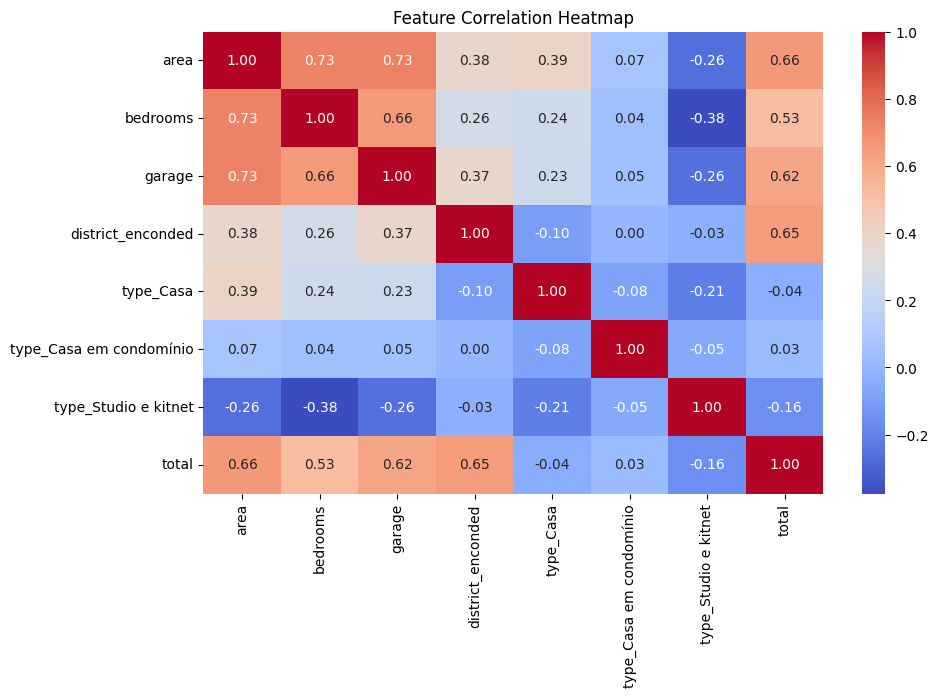

In [13]:
# eda = exploratory data analysis
eda_df = X_train.copy()
eda_df['total'] = y_train

# compute correlation matrix
corr_matrix = eda_df.corr()

# Plot Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

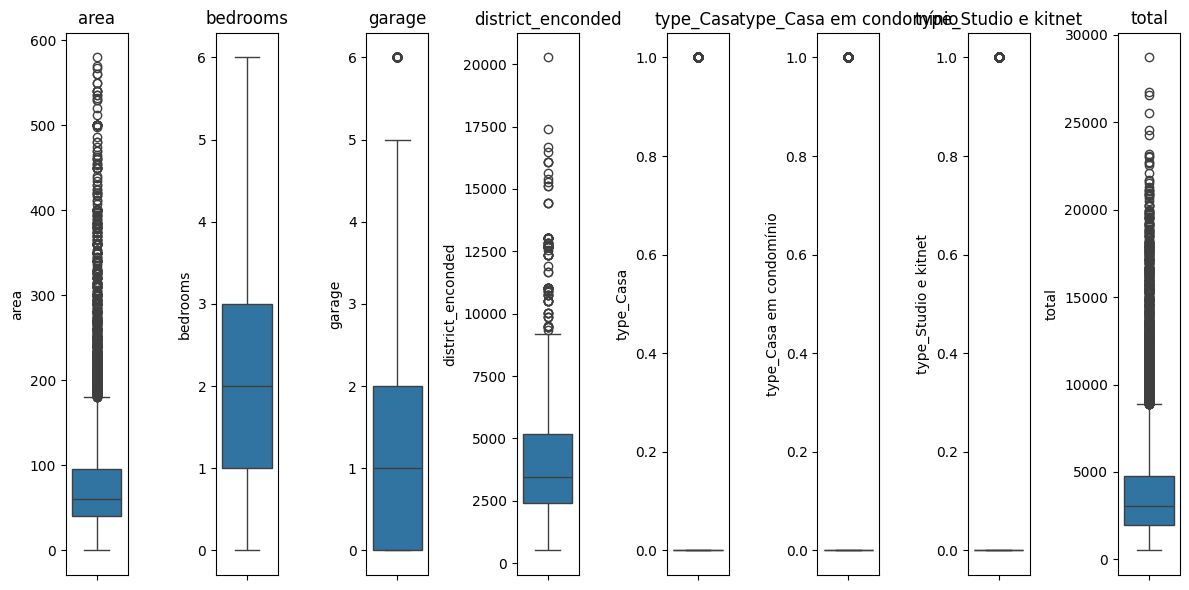

In [14]:
# Box plot method to visualize outliers

num_features = eda_df.columns.tolist()

# Plot boxplots (for outliers)
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_features, 1):
    plt.subplot(1, len(num_features), i)
    sns.boxplot(y=eda_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

SO FAR:
- Downloaded dataset
- Dropped rent and address columns, not important
- Encoded district and type and plotted to see corr with total price
NEXT:
- Check if my data is skewed, if it is transform it, then i believe we can train the model?

FEATURE SCALE (NORMALIZATION) - STARDARD SCALING

In [15]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ['area','bedrooms', 'garage', 'district_enconded']

scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])

# Fit the scaler on the training data and transform
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
# Transform the test data
X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [16]:
X_train_scaled.drop([col for col in X_train_scaled.columns if col.startswith('type_')], axis=1, inplace=True)

In [17]:
X_test_scaled.drop([col for col in X_test_scaled.columns if col.startswith('type_')], axis=1, inplace=True)
X_test.drop([col for col in X_test.columns if col.startswith('type_')], axis=1, inplace=True)
X_train.drop([col for col in X_train.columns if col.startswith('type_')], axis=1, inplace=True)

**Neural Network Impl**

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

#Step1 : DEFINE THE MODEL ARCHITECTURE

model = Sequential([
    #Input layer: 4 features
    Dense(64, activation='relu', input_dim=4),
    
    #Hidden NN Layers
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), # we can increase complexity later
    
    #Output Layer
    Dense(1) # output is 1 single value.
])



/Users/fernandotorres/dev-ai/houseprincing/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#Step 2: Compile the model

model.compile(
    optimizer='adam',
    loss='mean_absolute_error', #Loss used during training
    metrics=['mae', 'mape'] # Metrics for eval
)

In [20]:
#Step 3 Train the Model
# earlystopping to prevent overfitting by monitoring the validation loss.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # 20% of training data used for validation
    callbacks=[early_stop],
    verbose=1 # verbosity mode (1 = progress bar)
)



Epoch 1/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 4081.5139 - mae: 4081.5139 - mape: 97.8363 - val_loss: 2718.9727 - val_mae: 2718.9727 - val_mape: 58.9390
Epoch 2/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 2077.7146 - mae: 2077.7146 - mape: 50.0179 - val_loss: 1340.8199 - val_mae: 1340.8199 - val_mape: 37.2818
Epoch 3/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1342.6619 - mae: 1342.6619 - mape: 35.1637 - val_loss: 1224.8759 - val_mae: 1224.8759 - val_mape: 31.4384
Epoch 4/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 1262.3667 - mae: 1262.3667 - mape: 31.2176 - val_loss: 1192.9701 - val_mae: 1192.9701 - val_mape: 29.5496
Epoch 5/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 1240.7683 - mae: 1240.7683 - mape: 30.0370 - val_loss: 1177.4875 - val_mae: 1177.4875 - val_mape: 28.7316
Epoch 6/100
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 1229.9685 - mae: 1229.9685 - mape: 29.5272 - val_loss: 1168.4840 - val_mae: 1168.4840 - val_

In [21]:
#Step 4 : EVALUATE

test_loss, test_mae, test_mape = model.evaluate(X_test_scaled, y_test, verbose=1)


73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 1229.5592 - mae: 1229.5592 - mape: 31.4082


In [22]:
# ============================
# Step 5: Make Predictions
# ============================
# Generate predictions on the test data
y_pred = model.predict(X_test_scaled)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


In [23]:
# Evaluating

from sklearn.metrics import r2_score

y_test_array = np.array(y_test)

# Compute R2 Score
r2 = r2_score(y_test_array, y_pred)
print(f"R2 score: {r2:.2f}")

R2 score: 0.61


In [24]:
#Accuracy Score

# Tolerance
tolerance = 0.2

# Ensure the y_test is a numpy array
y_test_array = np.array(y_test).flatten()
y_pred_array = y_pred.flatten()

# Calculate the absolute percentage error for each prediction
percentage_errors = np.abs((y_test_array - y_pred_array) / y_test_array)

# Determine which predictions are within the tolerance
accurate_predictions = percentage_errors <= tolerance

# Compute the "accuracy" as the percentage of accurate predictions
accuracy_score = np.mean(accurate_predictions) * 100

print(f"Custom Accuracy Score: {accuracy_score:.2f}% (within ±{tolerance*100:.0f}% error)")


Custom Accuracy Score: 42.88% (within ±20% error)


custom input


In [25]:
print('Itaim Bibi' in X_view['district'].values)

False


In [31]:
import numpy as np

# Step 1: Define your custom input values (example values)
# Ensure these are in the same order as your training features
# For example: area, bedrooms, garage, district

custom_values = [180.3, 3, 2, "jardim europa"]

dist_value = district_means.get(custom_values[3].lower(), y_train.mean())

custom_values[3] = dist_value

# Step 2: Convert to a 2D NumPy array
custom_input = np.array([custom_values])  # Shape becomes (1, 4)

# Step 3: Scale the custom input using the same scaler from training
# (Assuming you have a scaler object named 'scaler' that was fit on X_train)
print(custom_input)
custom_input_scaled = scaler.transform(custom_input)
print(custom_input_scaled)

# Step 4: Predict using your trained model
predicted_price = model.predict(custom_input_scaled)

# Print the prediction (if your target variable is not scaled, it will be in the original units)
print(f"Predicted Price: {predicted_price[0][0]:.2f}")




[[1.8030e+02 3.0000e+00 2.0000e+00 7.5996e+03]]
[[1.28406653 1.11380414 0.82281417 1.62574611]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Price: 8831.49


/Users/fernandotorres/dev-ai/houseprincing/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


TODO: 
    - Medium Break Down
    - Linkedin Post
    - Next Project ( Ad Analyzer? ...)

In [35]:
import pickle
import joblib
import os

# Save y_mean
with open("models/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
    
# Save dist_mean dictionary
with open("models/district_means.pkl", "wb") as f:
    pickle.dump(district_means, f)
    
# Save scaler
joblib.dump(scaler, "models/scaler.pkl")

model.save("models/housing_model.keras")
print(os.path.exists("models/housing_model.keras"))

True
